In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# Class container for operations in the math graph
# _children will be a tuple
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        # It is going to store the chain rule at each node
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        
        # Here we are going to implement the derivative of the 'parent' node (neuron)
        # with respect to the chield nodes
        # p = parent, c1 = chield1, c2 = chield2
        # p = c1 + c2
        # dp/dc1 = 1 = dp/dc2
        # L = lost function (output of the last neuron)
        # dL/dc1 = dL/dp * dp/dc1
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other

    def __neg__(self): #-self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return (-self) + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        
        # p = parent, c1 = chield1, c2 = chield2
        # p = c1 * c2
        # dp/dc1 = c2
        # dp/dc2 = c1
        # L = lost function (output of the last neuron)
        # dL/dc1 = dL/dp * dp/dc1
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
    
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * (self.data ** (other-1))) * out.grad
            
        out._backward = _backward
        return out
    
    def __truediv__(self, other): # self / other
        # We can represent a division like a product or exponentiation
        # Like a product:  4/2 == 4 * (1/2) == 4 * 2^-1
        # a/b == a*(1/b) == a*(b**-1)
        return self * other**(-1)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')
        
        # p = parent, c1 = chield1
        # p = tanh(c1)
        # dp/dc1 = 1 - tanh(c1)^2
        # dp/dc1 = 1 - p^2
        # L = lost function (output of the last neuron)
        # dL/dc1 = dL/dp * dp/dc1
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = [] # Nodes (Neurons) ordered backward according to the graph
        visited = set()

        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for chield in node._prev:
                    build_topo(chield)
                topo.append(node)

        build_topo(self)
        self.grad = 1.0 # Initial derivative of the last note with respect itself
        for node in reversed(topo):
            node._backward()    

In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(node):
        # Add the current node to the nodes if not present
        if node not in nodes:
            nodes.add(node)
            #print(f"{node.data}, child: {node._prev}, operation: {node._op}")
        # For every child of node save the child and node in edges, and add
        # the child as other node calling build(child)
        for child in node._prev:
            edges.add((child, node))
            build(child)
            
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    #print("\n")
    #print(f"nodes: {nodes}\nedges: {edges}")
    for nod in nodes:
        uid = str(id(nod))
        # For any value in the graph, create a rectangular 'record' node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (nod.label, nod.data, nod.grad), shape='record')
        if nod._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + nod._op, label=nod._op)
            # and connect this node to it
            dot.edge(uid + nod._op, uid)
            
    for nod1, nod2 in edges:
        # Connect nod1 to the op node of nod2
        dot.edge(str(id(nod1)), str(id(nod2)) + nod2._op)
    
    return dot
        
      

In [4]:
import torch

In [5]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [6]:
class Neuron:
    
    # number_of_inputs: Represents the number of inputs of the current neuron
    def __init__(self, number_of_inputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(number_of_inputs)]
        self.b = Value(random.uniform(-1, 1))
        
    
    def __call__(self, x):
        # w * x + b
        # The zip function convert independent iterables to an iterator of tuples
        # where each tuple contains elements from the iterables that are passed
        # i.e,. [(Value(data=0.47475612646024135), 2.0), (Value(data=-0.5039990198247326), 3.0)]
        activation_value = sum(wi*xi for wi, xi in zip(self.w, x))
        out = activation_value.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    # number_of_inputs: Number of inputs for each neuron
    # number_of_outputs: Number of outputs in this layer (number of neurons)
    def __init__(self, number_of_inputs, number_of_outputs):
        self.neurons = [Neuron(number_of_inputs) for _ in range(number_of_outputs)]
    
    def __call__(self, x):
        # Calculate the output of each neuron in this layer
        outs = [neuron(x) for neuron in self.neurons]
        # Return the scalar value if the list has size 1 otherwise return the list
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            neron_params = neuron.parameters()
            params.extend(neron_params)
            
        return params
    
# Multilayer perceptron
class MLP:
    
    # number_of_inputs: Number of inputs for the first neuron
    # list_number_of_outputs: Number of outputs for each layer (number of neurons for each layer)
    def __init__(self, number_of_inputs, list_number_of_outputs):
        # Where we are concatenating both lists
        sz = [number_of_inputs] + list_number_of_outputs
        print(f'sz: {sz}')
        self.layers = [Layer(number_of_inputs=sz[i], number_of_outputs=sz[i+1]) for i in range(len(list_number_of_outputs))]
        
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    
    def parameters(self):
        params = []
        for layer in self.layers:
            layer_params = layer.parameters()
            params.extend(layer_params)
            
        return params


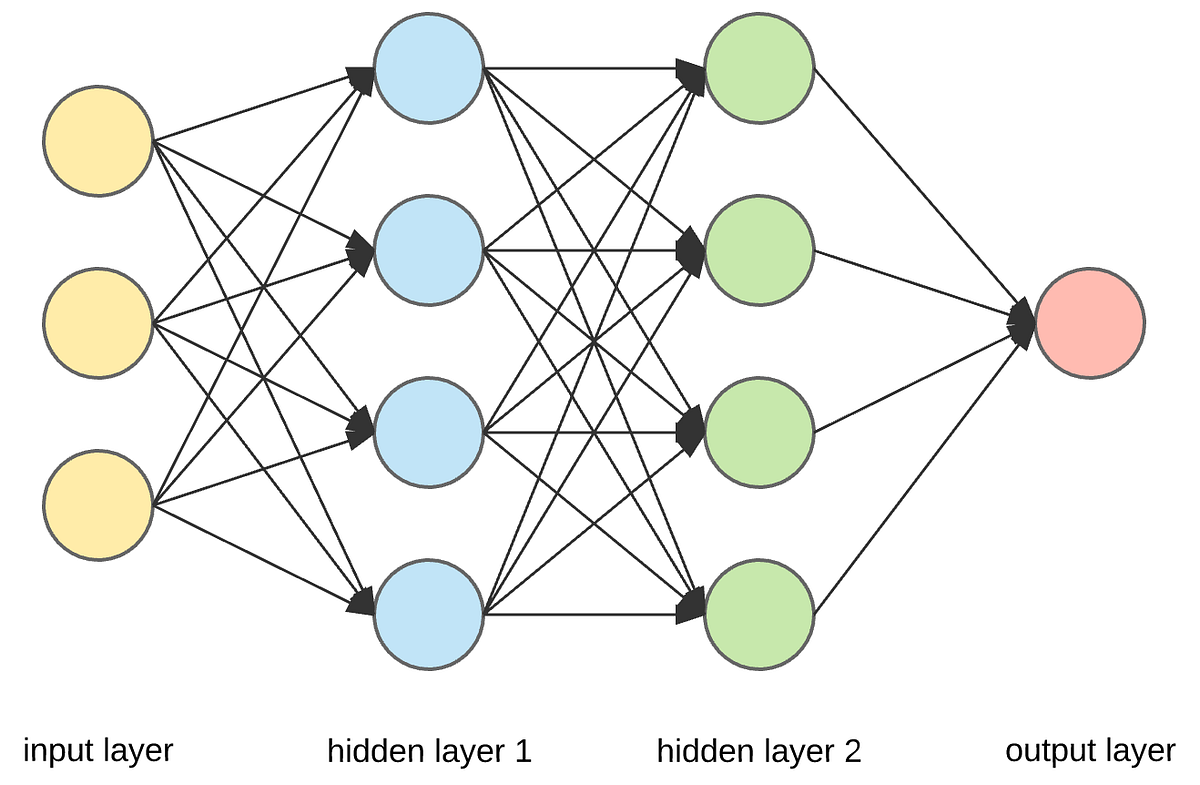

In [176]:
x = [2.0, 3.0, -1]
mlp = MLP(number_of_inputs=3, list_number_of_outputs=[4, 4, 1])
mlp(x)

sz: [3, 4, 4, 1]


Value(data=0.8389529539189137)

In [8]:
mlp.parameters()

[Value(data=0.693087162124534),
 Value(data=-0.5108015320239774),
 Value(data=0.9031032005261932),
 Value(data=-0.8151188263253009),
 Value(data=0.13659305637947328),
 Value(data=0.3254715315202914),
 Value(data=0.35991082422850784),
 Value(data=0.19955124005803437),
 Value(data=-0.5863710985951591),
 Value(data=-0.13833559509160365),
 Value(data=-0.22966943588557642),
 Value(data=-0.04155565096370095),
 Value(data=-0.6502684032613979),
 Value(data=-0.9721549750690264),
 Value(data=0.17619736893995985),
 Value(data=0.0991891738829298),
 Value(data=-0.14691812954780237),
 Value(data=0.1325845035766995),
 Value(data=0.08896745121623084),
 Value(data=0.5872636389687111),
 Value(data=0.5082382732067912),
 Value(data=0.46234840760863816),
 Value(data=0.013601893206157234),
 Value(data=-0.022082693795192343),
 Value(data=0.4904288604326361),
 Value(data=0.6869898839578961),
 Value(data=-0.4884410575949625),
 Value(data=0.5581247517941532),
 Value(data=0.894584817295834),
 Value(data=0.363720

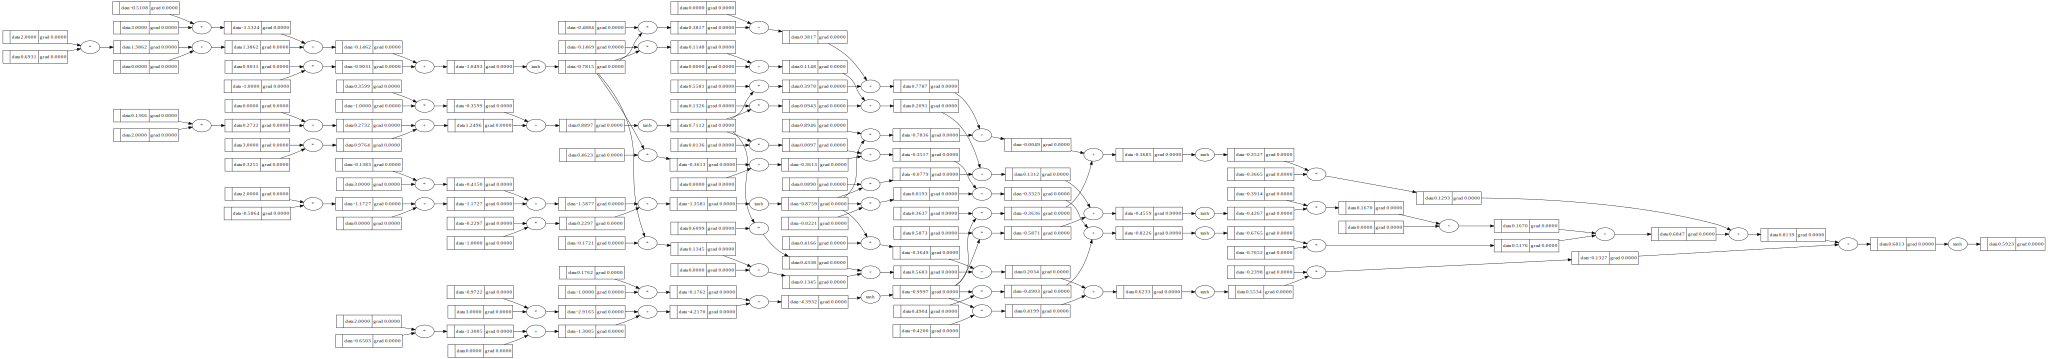

In [9]:
draw_dot(mlp(x))

### Datasets and the cost function

In [20]:
# Let see how it looks like when we pass a dataset

# Input data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

In [11]:
# We need to tune the weights to better predict the desired targets,
# to achieve this we are going to calculate a single number that measures the total performance
# of the neural network (Loss)

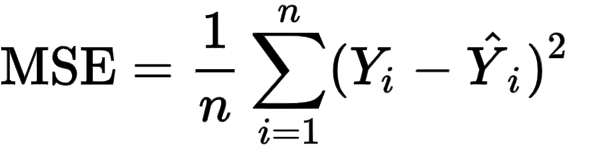 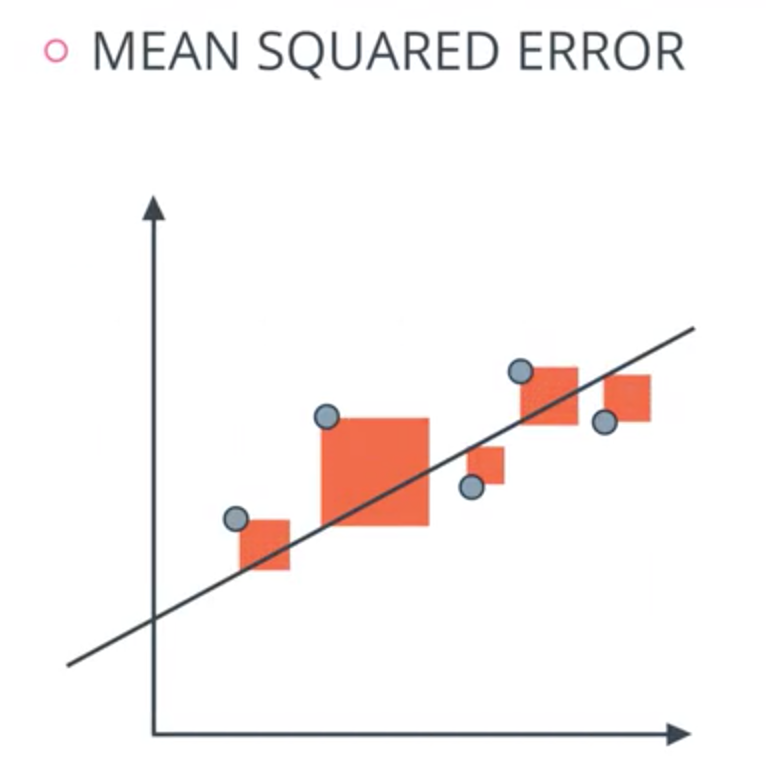

In [ ]:
# Here we are getting the forward propagation value for the last layer
# for each input data (Which consists of 3 features)
y_pred = [mlp(x) for x in xs]
y_pred

In [171]:
# The loss functions we are going to use is the Mean Square Error (MSE)
loss = sum([(y_ground_true - y_output)**2 for y_ground_true, y_output in zip(ys, y_pred)])
print(loss)

Value(data=0.0008155935197583306)


In [165]:
## We want to minimize the loss what means that the prediction be closed to the ground true labels
loss.backward()

In [166]:
# For example after runing the backward propagation we can see the influence each neuron
# has in the loss, in this case the influence is negative.

# For this neuron, increasing this particular weight of this neuron of this layer
# would make the loss go down. This is the logic we want to apply for every weigh in each neuron
# in each layer
mlp.layers[0].neurons[0].w[0].grad

3.660518642213367

In [167]:
mlp.layers[0].neurons[0].w[0].data

0.059577908661889487

### Update the parameters

In [168]:
# We want to update the parameters data slightly according to the gradien information
# The gradient for each weight indicates how much a small change in that weight would affect the loss function.
# It's a measure of the weight's influence on the final output.
# Positive and Negative Gradients:
# Positive Gradient: If the gradient of a weight is positive, it means that increasing the weight slightly will
# increase the loss. Conversely, decreasing the weight will reduce the loss.
# Negative Gradient: If the gradient is negative, then increasing the weight will decrease the loss, 
# and decreasing the weight will increase the loss.
# Gradient Descent: In the context of training, you typically adjust the weights in the opposite direction
# of the gradient to minimize the loss. 
# This process is known as gradient descent. If a weight's gradient is positive, you reduce the weight;
# if it's negative, you increase the weight.

# Learning Rate: The magnitude of these adjustments is controlled by the learning rate. A higher learning rate makes bigger adjustments to the weights.
for parameter in mlp.parameters():
    parameter.data += -0.01 * parameter.grad

In [169]:
mlp.layers[0].neurons[0].w[0].data

0.022972722239755813

In [172]:
y_pred

[Value(data=0.9841607189369138),
 Value(data=-0.9946196085153015),
 Value(data=-0.9846521621415508),
 Value(data=0.9826735475152867)]

### Automatic forward, backward propagation and parameters update

In [238]:
x = [2.0, 3.0, -1]
mlp = MLP(number_of_inputs=3, list_number_of_outputs=[4, 4, 1])
mlp(x)

sz: [3, 4, 4, 1]


Value(data=-0.04655198569336979)

In [252]:
# Let see how it looks like when we pass a dataset

# Input data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

In [265]:
for k in range(20):
    # Forward pass
    y_pred = [mlp(x) for x in xs]
    loss = sum([(y_ground_true - y_output)**2 for y_ground_true, y_output in zip(ys, y_pred)])
    
    # Backward pass
    # We need to reset to zero the parameter.grad before calculate again these values
    # through backward propagation
    for parameter in mlp.parameters():
        parameter.grad = 0.0
    loss.backward()
    
    # Update of gradients
    # Where -0.05 is the learning rate
    for parameter in mlp.parameters():
        parameter.data += -0.05 * parameter.grad
        
    print(k, loss.data)

0 0.0023730719768588105
1 0.00236194905007357
2 0.002350926318442738
3 0.002340002454571126
4 0.0023291761542051656
5 0.002318446135733675
6 0.002307811139701372
7 0.0022972699283349456
8 0.0022868212850810617
9 0.0022764640141561343
10 0.0022661969401075645
11 0.0022560189073858594
12 0.0022459287799275213
13 0.0022359254407483603
14 0.002226007791546915
15 0.0022161747523176687
16 0.0022064252609737584
17 0.0021967582729790274
18 0.0021871727609889817
19 0.0021776677145005398


In [266]:
y_pred

[Value(data=0.972881696401609),
 Value(data=-0.9771542549642123),
 Value(data=-0.9779121352787734),
 Value(data=0.9792042434553919)]